# Tree Classification with Transfer Learning

Jani Timmerheid

## Dataset:
https://www.kaggle.com/datasets/erickendric/tree-dataset-of-urban-street-classification-tree

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from collections import defaultdict
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.metrics import top_k_accuracy_score
from glob import glob

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

torch.manual_seed(42)
np.random.seed(42)

Using device: cuda:0


In [16]:
data_dir = './tree_dataset'
batch_size = 32
num_epochs = 10
learning_rate = 0.001
momentum = 0.9
step_size = 7
gamma = 0.1
input_size = 224
num_classes = None

In [17]:
def get_data_transforms():
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(input_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize(input_size + 32),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize(input_size + 32),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    }
    return data_transforms

### Data Augmentation Techniques

In this notebook, data augmentation was applied to the training dataset to improve the model's generalization ability. The following augmentations were used:

1. **RandomResizedCrop**:
    - Randomly crops and resizes the image to the specified input size (`224x224`).
    - **Reason**: Introduces variability in the spatial composition of the images, helping the model become robust to different object positions and scales.

2. **RandomHorizontalFlip**:
    - Randomly flips the image horizontally with a probability of 50%.
    - **Reason**: Simulates variations in the orientation of trees, which can occur naturally in real-world scenarios.

3. **Normalization**:
    - Normalizes the image pixel values using the mean `[0.485, 0.456, 0.406]` and standard deviation `[0.229, 0.224, 0.225]`.
    - **Reason**: Standardizes the input data to match the distribution of the pre-trained ResNet models, which were trained on the ImageNet dataset.

In [18]:
def load_dataset():
    global num_classes
    data_transforms = get_data_transforms()
    
    datasets_dict = {}
    dataloaders_dict = {}
    
    for phase in ['train', 'val', 'test']:
        dataset_path = os.path.join(data_dir, phase)
        if os.path.exists(dataset_path):
            datasets_dict[phase] = datasets.ImageFolder(dataset_path, data_transforms[phase])
            dataloaders_dict[phase] = torch.utils.data.DataLoader(
                datasets_dict[phase], 
                batch_size=batch_size,
                shuffle=(phase == 'train'), 
                num_workers=4
            )
            print(f"{phase} dataset: {len(datasets_dict[phase])} images")
    
    if 'train' in datasets_dict:
        num_classes = len(datasets_dict['train'].classes)
        class_names = datasets_dict['train'].classes
        print(f"Classes: {num_classes}")
    
    return dataloaders_dict, class_names

dataloaders, class_names = load_dataset()

train dataset: 3850 images
val dataset: 482 images
test dataset: 472 images
Classes: 23


In [19]:
def create_resnet18_model(num_classes):
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

def create_resnet50_model(num_classes):
    model = models.resnet50(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

def create_feature_extractor(model_name, num_classes):
    if model_name == "resnet18":
        model = models.resnet18(pretrained=True)
    elif model_name == "resnet50":
        model = models.resnet50(pretrained=True)
    
    for param in model.parameters():
        param.requires_grad = False
    
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

def get_model(model_name, num_classes, feature_extract=False):
    if feature_extract:
        return create_feature_extractor(model_name, num_classes)
    else:
        if model_name == "resnet18":
            return create_resnet18_model(num_classes)
        elif model_name == "resnet50":
            return create_resnet50_model(num_classes)

In [20]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.cpu().numpy())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.cpu().numpy())
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
    
    print(f'Best val Acc: {best_acc:.4f}')
    model.load_state_dict(best_model_wts)
    return model, history

In [21]:
def evaluate_model(model, dataloader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, support = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted', zero_division=0
    )
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    return {
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_probs,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Training Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {title}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [22]:
def analyze_n_best_performance(models_results, class_names, max_k=None):
    if max_k is None:
        max_k = len(class_names)
    
    k_values = list(range(1, min(max_k + 1, len(class_names) + 1)))
    model_names = list(models_results.keys())
    n_best_results = {model: {} for model in model_names}
    
    print("N-Best Classification Analysis")
    print("=" * 60)
    
    for model_name, results in models_results.items():
        probabilities = results['probabilities']
        labels = results['labels']
        
        print(f"{model_name}:")
        
        for k in k_values:
            top_k_acc = top_k_accuracy_score(labels, probabilities, k=k)
            n_best_results[model_name][k] = top_k_acc
            print(f"Top-{k}: {top_k_acc:.4f}")
    
    comparison_df = pd.DataFrame(n_best_results).T
    comparison_df.columns = [f'Top-{k}' for k in k_values]
    
    print("N-Best Performance Comparison:")
    print(comparison_df.round(4))
    
    plt.figure(figsize=(12, 6))
    
    for model_name in model_names:
        accuracies = [n_best_results[model_name][k] for k in k_values]
        plt.plot(k_values, accuracies, marker='o', label=model_name, linewidth=2)
    
    plt.xlabel('k (Top-k)')
    plt.ylabel('Top-k Accuracy')
    plt.title('N-Best Classification Performance Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(k_values)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()
    
    print(f"Performance Separation Analysis:")
    
    separation_analysis = []
    for k in k_values:
        accuracies = [n_best_results[model][k] for model in model_names]
        max_diff = max(accuracies) - min(accuracies)
        std_diff = np.std(accuracies)
        separation_analysis.append({
            'k': k,
            'max_difference': max_diff,
            'std_deviation': std_diff,
            'range': max_diff
        })
        print(f"k={k}: Max Diff={max_diff:.4f}, Std Dev={std_diff:.4f}")
    
    max_separation_k = max(separation_analysis, key=lambda x: x['max_difference'])
    print(f"Maximum model separation occurs at k={max_separation_k['k']} with difference of {max_separation_k['max_difference']:.4f}")
    
    plt.figure(figsize=(10, 6))
    k_vals = [item['k'] for item in separation_analysis]
    max_diffs = [item['max_difference'] for item in separation_analysis]
    std_devs = [item['std_deviation'] for item in separation_analysis]
    
    plt.subplot(1, 2, 1)
    plt.plot(k_vals, max_diffs, 'ro-', label='Max Difference')
    plt.xlabel('k')
    plt.ylabel('Maximum Difference')
    plt.title('Model Performance Separation vs k')
    plt.grid(True, alpha=0.3)
    plt.xticks(k_vals)
    
    plt.subplot(1, 2, 2)
    plt.plot(k_vals, std_devs, 'bo-', label='Standard Deviation')
    plt.xlabel('k')
    plt.ylabel('Standard Deviation')
    plt.title('Performance Variance vs k')
    plt.grid(True, alpha=0.3)
    plt.xticks(k_vals)
    
    plt.tight_layout()
    plt.show()
    
    return n_best_results, comparison_df, separation_analysis


In [23]:
def simple_dataset_analysis(data_dir, class_names):
    dataset_stats = {'train': {}, 'val': {}, 'test': {}}
    
    for phase in ['train', 'val', 'test']:
        phase_dir = os.path.join(data_dir, phase)
        if os.path.exists(phase_dir):
            total_images = 0
            class_counts = {}
            
            for class_name in class_names:
                class_dir = os.path.join(phase_dir, class_name)
                if os.path.exists(class_dir):
                    num_images = len(glob(os.path.join(class_dir, '*')))
                    class_counts[class_name] = num_images
                    total_images += num_images
            
            dataset_stats[phase]['total_images'] = total_images
            dataset_stats[phase]['class_counts'] = class_counts
            
            print(f"{phase.capitalize()} Dataset:")
            print(f"  Total Images: {total_images}")
            for class_name, count in class_counts.items():
                print(f"  {class_name}: {count} images")
            print()
        else:
            print(f"{phase.capitalize()} directory not found in {data_dir}")
    
    return dataset_stats

In [24]:
def train_models(dataloaders, class_names, num_classes):
    models_to_train = [
        ('resnet18', False),
        ('resnet50', False), 
        ('resnet18', True),
        ('resnet50', True)
    ]
    
    results = {}
    training_histories = {}
    trained_models = {}
    
    for model_name, feature_extract in models_to_train:
        model_key = f"{model_name}{'_feature_extract' if feature_extract else ''}"
        print(f"Training {model_key}")
        
        model = get_model(model_name, num_classes, feature_extract)
        model = model.to(device)
        
        criterion = nn.CrossEntropyLoss()
        
        if feature_extract:
            optimizer = optim.SGD(model.fc.parameters(), lr=learning_rate, momentum=momentum)
            print("Feature extraction mode: only training final layer")
        else:
            optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
            print("Finetuning mode: training all layers")
        
        scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
        
        model, history = train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs)
        training_histories[model_key] = history
        trained_models[model_key] = model
        
        plot_training_history(history, model_key)
        
        if 'test' in dataloaders:
            print(f"Evaluating {model_key} on test set...")
            eval_results = evaluate_model(model, dataloaders['test'], class_names)
            results[model_key] = eval_results
            
            plot_confusion_matrix(
                eval_results['labels'], eval_results['predictions'], 
                class_names, model_key
            )
        
        model_filename = f'{model_key}_tree_classifier.pth'
        torch.save(model.state_dict(), model_filename)
        print(f"Model saved as {model_filename}")
    
    return results, training_histories, trained_models

def compare_models(results):
    print("Model Comparison:")
    for model_name, result in results.items():
        print(f"{model_name}: Accuracy={result['accuracy']:.3f}, F1={result['f1']:.3f}")

## Dataset Setup

Download dataset and put it in tree_dataset/ folder with train/val/test structure.

In [25]:
dataloaders, class_names = load_dataset()
print(f"Dataset loaded successfully!")
print(f"Classes: {class_names}")

train dataset: 3850 images
val dataset: 482 images
test dataset: 472 images
Classes: 23
Dataset loaded successfully!
Classes: ['Acer palmatum', 'Cedrus deodara', 'Celtis sinensis', 'Cinnamomum camphora (Linn) Presl', 'Elaeocarpus decipiens', 'Flowering cherry', 'Ginkgo biloba', 'Koelreuteria paniculata', 'Lagerstroemia indica', 'Liquidambar formosana', 'Liriodendron chinense', 'Magnolia grandiflora L', 'Magnolia liliflora Desr', 'Michelia chapensis', 'Osmanthus fragrans', 'Photinia serratifolia', 'Platanus', 'Prunus cerasifera f. atropurpurea', 'Salix babylonica', 'Sapindus saponaria', 'Styphnolobium japonicum', 'Triadica sebifera', 'Zelkova serrata']
val dataset: 482 images
test dataset: 472 images
Classes: 23
Dataset loaded successfully!
Classes: ['Acer palmatum', 'Cedrus deodara', 'Celtis sinensis', 'Cinnamomum camphora (Linn) Presl', 'Elaeocarpus decipiens', 'Flowering cherry', 'Ginkgo biloba', 'Koelreuteria paniculata', 'Lagerstroemia indica', 'Liquidambar formosana', 'Liriodendro


### Dataset Description

The dataset used in this notebook is a collection of tree images for urban street classification. It contains images of 23 different tree species, organized into three subsets: training, validation, and testing. Each subset is structured into folders, where each folder corresponds to a specific tree species.

#### Tree Species:
The dataset includes the following 23 classes:
1. Acer palmatum
2. Cedrus deodara
3. Celtis sinensis
4. Cinnamomum camphora (Linn) Presl
5. Elaeocarpus decipiens
6. Flowering cherry
7. Ginkgo biloba
8. Koelreuteria paniculata
9. Lagerstroemia indica
10. Liquidambar formosana
11. Liriodendron chinense
12. Magnolia grandiflora L
13. Magnolia liliflora Desr
14. Michelia chapensis
15. Osmanthus fragrans
16. Photinia serratifolia
17. Platanus
18. Prunus cerasifera f. atropurpurea
19. Salix babylonica
20. Sapindus saponaria
21. Styphnolobium japonicum
22. Triadica sebifera
23. Zelkova serrata

#### Dataset Statistics:
- **Training Set**: 3,850 images
- **Validation Set**: 482 images
- **Test Set**: 472 images

Each image is labeled with its corresponding tree species, and the dataset is designed to support supervised learning tasks such as classification. The dataset also includes a balanced distribution of images across the classes to ensure fair training and evaluation.

In [26]:
dataset_stats = simple_dataset_analysis(data_dir, class_names)

Train Dataset:
  Total Images: 3850
  Acer palmatum: 162 images
  Cedrus deodara: 125 images
  Celtis sinensis: 188 images
  Cinnamomum camphora (Linn) Presl: 234 images
  Elaeocarpus decipiens: 172 images
  Flowering cherry: 106 images
  Ginkgo biloba: 228 images
  Koelreuteria paniculata: 223 images
  Lagerstroemia indica: 65 images
  Liquidambar formosana: 168 images
  Liriodendron chinense: 182 images
  Magnolia grandiflora L: 212 images
  Magnolia liliflora Desr: 190 images
  Michelia chapensis: 154 images
  Osmanthus fragrans: 173 images
  Photinia serratifolia: 120 images
  Platanus: 193 images
  Prunus cerasifera f. atropurpurea: 99 images
  Salix babylonica: 136 images
  Sapindus saponaria: 224 images
  Styphnolobium japonicum: 157 images
  Triadica sebifera: 154 images
  Zelkova serrata: 185 images

Val Dataset:
  Total Images: 482
  Acer palmatum: 21 images
  Cedrus deodara: 16 images
  Celtis sinensis: 24 images
  Cinnamomum camphora (Linn) Presl: 29 images
  Elaeocarpus de

## Training Pipeline

Once your dataset is loaded, run the complete training and evaluation pipeline:

Training resnet18


C:\Users\janit\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\janit\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Finetuning mode: training all layers
Epoch 1/10
train Loss: 2.6747 Acc: 0.2309
train Loss: 2.6747 Acc: 0.2309
val Loss: 1.7764 Acc: 0.5415
Epoch 2/10
val Loss: 1.7764 Acc: 0.5415
Epoch 2/10
train Loss: 1.6856 Acc: 0.5353
train Loss: 1.6856 Acc: 0.5353
val Loss: 1.0692 Acc: 0.7054
Epoch 3/10
val Loss: 1.0692 Acc: 0.7054
Epoch 3/10
train Loss: 1.1986 Acc: 0.6574
train Loss: 1.1986 Acc: 0.6574
val Loss: 0.7177 Acc: 0.8008
Epoch 4/10
val Loss: 0.7177 Acc: 0.8008
Epoch 4/10
train Loss: 0.9379 Acc: 0.7400
train Loss: 0.9379 Acc: 0.7400
val Loss: 0.5888 Acc: 0.8340
Epoch 5/10
val Loss: 0.5888 Acc: 0.8340
Epoch 5/10
train Loss: 0.7952 Acc: 0.7706
train Loss: 0.7952 Acc: 0.7706
val Loss: 0.5110 Acc: 0.8568
Epoch 6/10
val Loss: 0.5110 Acc: 0.8568
Epoch 6/10
train Loss: 0.6889 Acc: 0.7951
train Loss: 0.6889 Acc: 0.7951
val Loss: 0.4745 Acc: 0.8589
Epoch 7/10
val Loss: 0.4745 Acc: 0.8589
Epoch 7/10
train Loss: 0.6138 Acc: 0.8281
train Loss: 0.6138 Acc: 0.8281
val Loss: 0.3699 Acc: 0.8963
Epoch 8/1

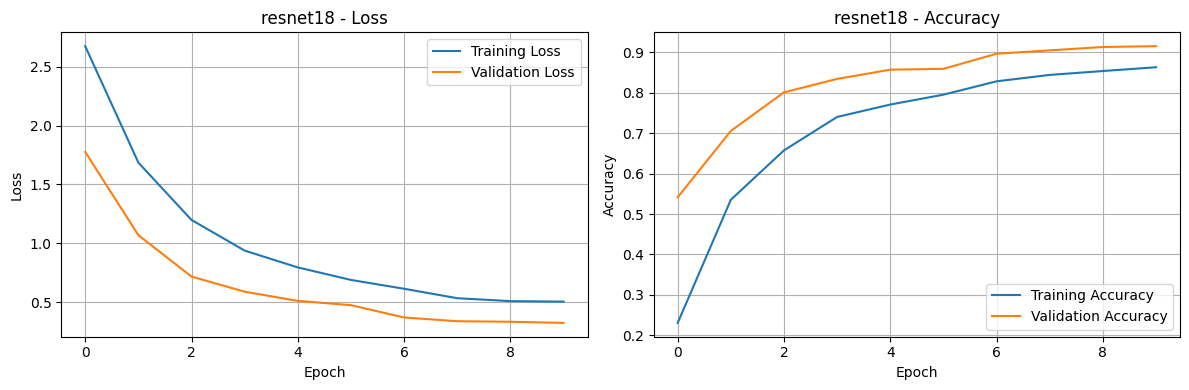

Evaluating resnet18 on test set...
Accuracy: 0.8475
Precision: 0.8630
Recall: 0.8475
F1-Score: 0.8444
Accuracy: 0.8475
Precision: 0.8630
Recall: 0.8475
F1-Score: 0.8444


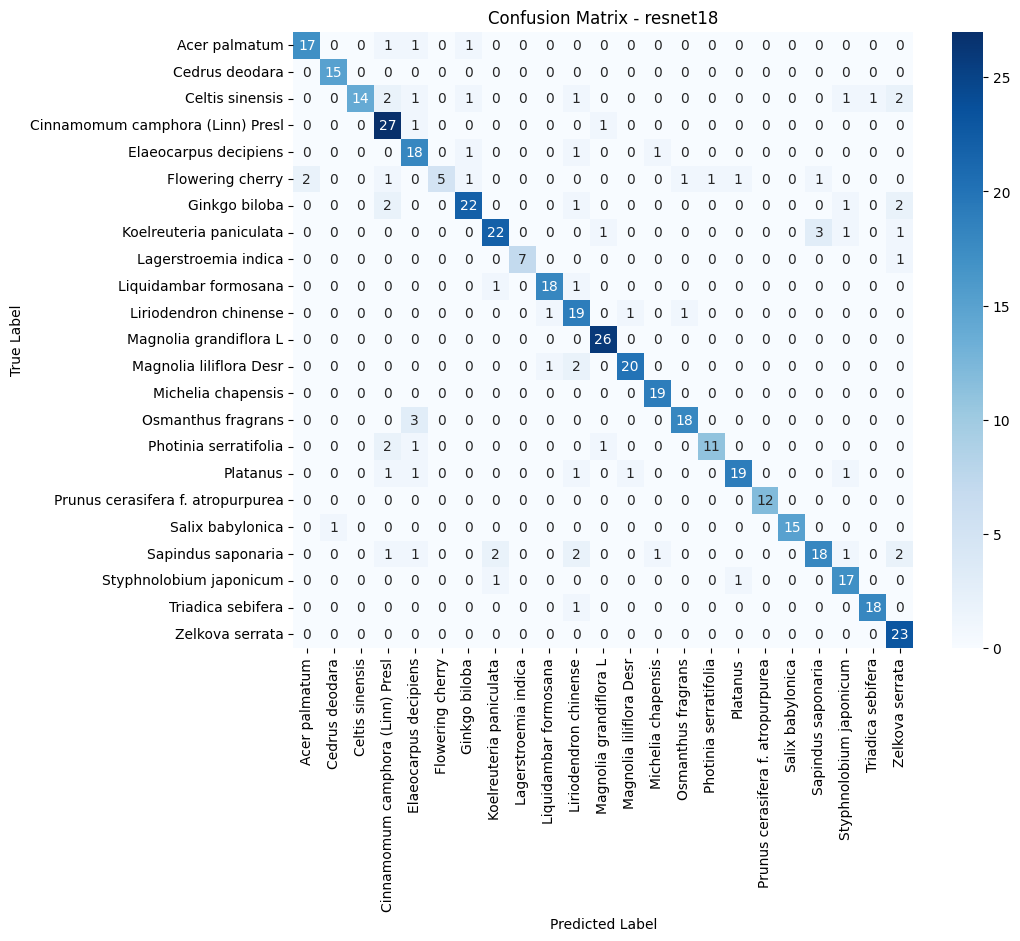

Model saved as resnet18_tree_classifier.pth
Training resnet50


C:\Users\janit\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\janit\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Finetuning mode: training all layers
Epoch 1/10
train Loss: 2.6941 Acc: 0.2530
train Loss: 2.6941 Acc: 0.2530
val Loss: 1.7566 Acc: 0.5747
Epoch 2/10
val Loss: 1.7566 Acc: 0.5747
Epoch 2/10
train Loss: 1.5870 Acc: 0.5961
train Loss: 1.5870 Acc: 0.5961
val Loss: 0.8887 Acc: 0.7718
Epoch 3/10
val Loss: 0.8887 Acc: 0.7718
Epoch 3/10
train Loss: 1.0081 Acc: 0.7283
train Loss: 1.0081 Acc: 0.7283
val Loss: 0.5780 Acc: 0.8216
Epoch 4/10
val Loss: 0.5780 Acc: 0.8216
Epoch 4/10
train Loss: 0.7681 Acc: 0.7860
train Loss: 0.7681 Acc: 0.7860
val Loss: 0.3919 Acc: 0.8859
Epoch 5/10
val Loss: 0.3919 Acc: 0.8859
Epoch 5/10
train Loss: 0.6386 Acc: 0.8125
train Loss: 0.6386 Acc: 0.8125
val Loss: 0.3316 Acc: 0.9046
Epoch 6/10
val Loss: 0.3316 Acc: 0.9046
Epoch 6/10
train Loss: 0.4934 Acc: 0.8706
train Loss: 0.4934 Acc: 0.8706
val Loss: 0.2695 Acc: 0.9315
Epoch 7/10
val Loss: 0.2695 Acc: 0.9315
Epoch 7/10
train Loss: 0.4280 Acc: 0.8769
train Loss: 0.4280 Acc: 0.8769
val Loss: 0.2659 Acc: 0.9087
Epoch 8/1

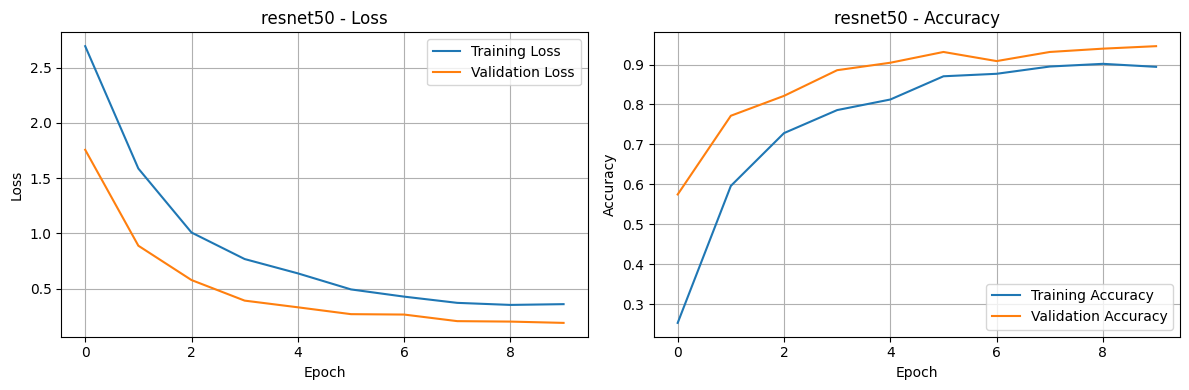

Evaluating resnet50 on test set...
Accuracy: 0.8919
Precision: 0.9059
Recall: 0.8919
F1-Score: 0.8923
Accuracy: 0.8919
Precision: 0.9059
Recall: 0.8919
F1-Score: 0.8923


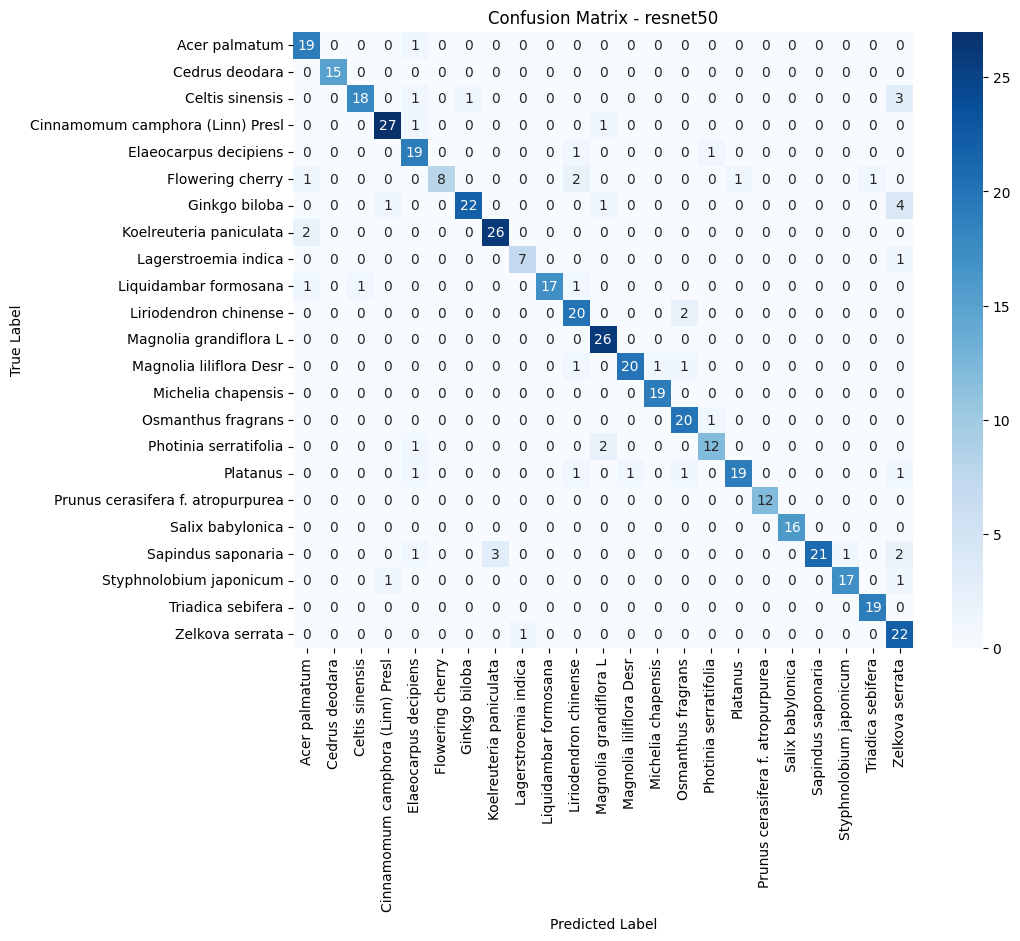

Model saved as resnet50_tree_classifier.pth
Training resnet18_feature_extract
Feature extraction mode: only training final layer


C:\Users\janit\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\janit\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10
train Loss: 2.9474 Acc: 0.1462
train Loss: 2.9474 Acc: 0.1462
val Loss: 2.6192 Acc: 0.2801
Epoch 2/10
val Loss: 2.6192 Acc: 0.2801
Epoch 2/10
train Loss: 2.5305 Acc: 0.3034
train Loss: 2.5305 Acc: 0.3034
val Loss: 2.2780 Acc: 0.3880
Epoch 3/10
val Loss: 2.2780 Acc: 0.3880
Epoch 3/10
train Loss: 2.2918 Acc: 0.3784
train Loss: 2.2918 Acc: 0.3784
val Loss: 2.0102 Acc: 0.4730
Epoch 4/10
val Loss: 2.0102 Acc: 0.4730
Epoch 4/10
train Loss: 2.1363 Acc: 0.4158
train Loss: 2.1363 Acc: 0.4158
val Loss: 1.8356 Acc: 0.4938
Epoch 5/10
val Loss: 1.8356 Acc: 0.4938
Epoch 5/10
train Loss: 1.9982 Acc: 0.4636
train Loss: 1.9982 Acc: 0.4636
val Loss: 1.7273 Acc: 0.5353
Epoch 6/10
val Loss: 1.7273 Acc: 0.5353
Epoch 6/10
train Loss: 1.9134 Acc: 0.4784
train Loss: 1.9134 Acc: 0.4784
val Loss: 1.6464 Acc: 0.5311
Epoch 7/10
val Loss: 1.6464 Acc: 0.5311
Epoch 7/10
train Loss: 1.8317 Acc: 0.4979
train Loss: 1.8317 Acc: 0.4979
val Loss: 1.6021 Acc: 0.5622
Epoch 8/10
val Loss: 1.6021 Acc: 0.5622
Epoch 

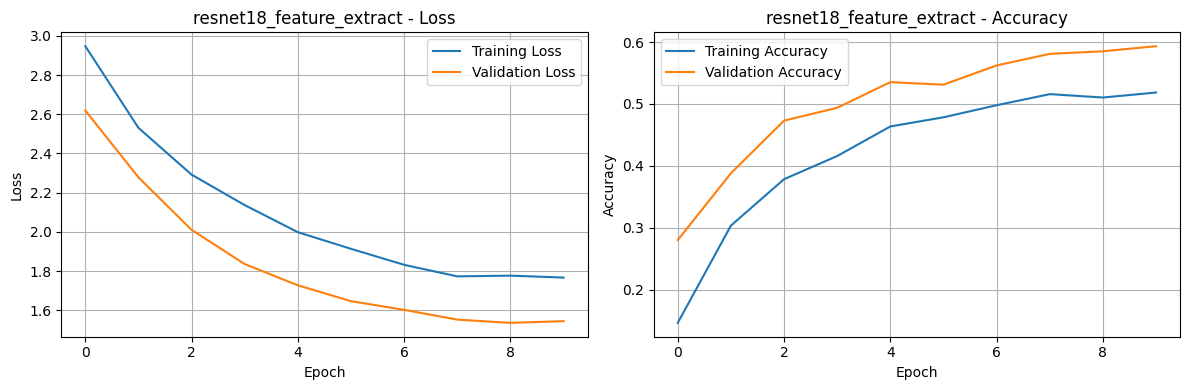

Evaluating resnet18_feature_extract on test set...
Accuracy: 0.5614
Precision: 0.5638
Recall: 0.5614
F1-Score: 0.5428
Accuracy: 0.5614
Precision: 0.5638
Recall: 0.5614
F1-Score: 0.5428


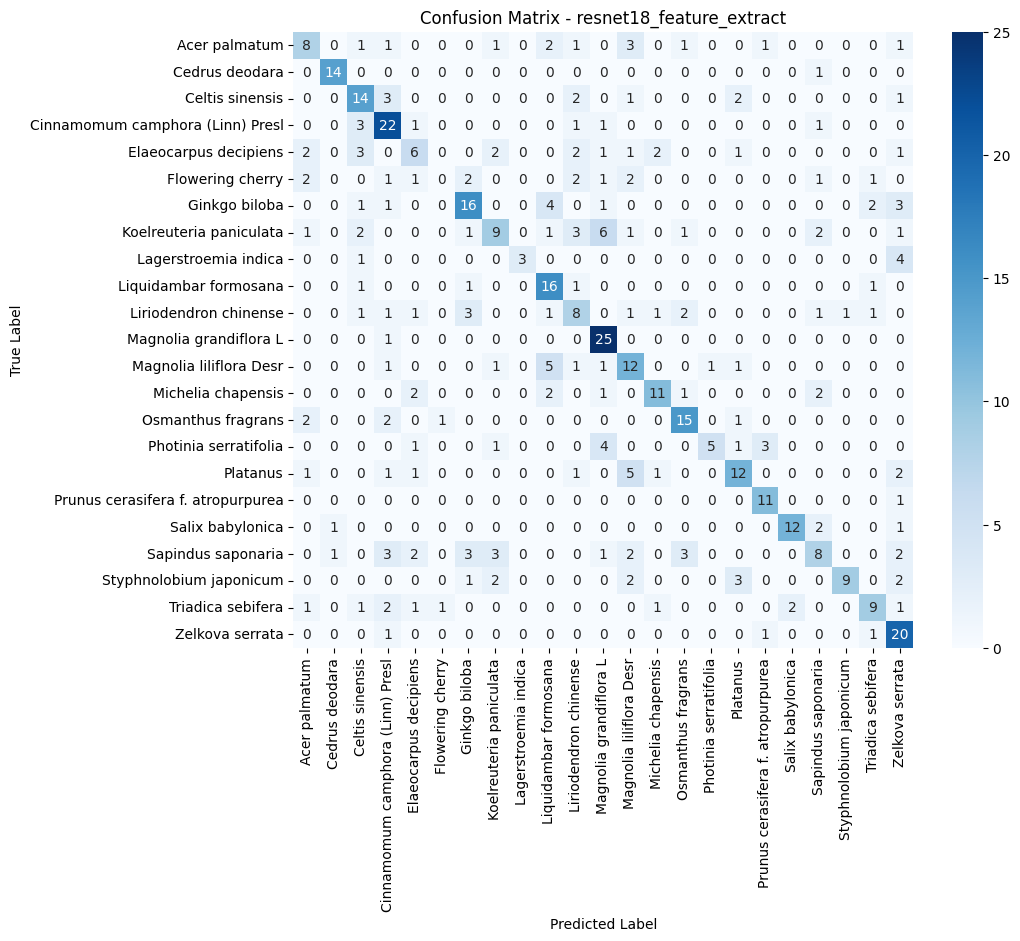

Model saved as resnet18_feature_extract_tree_classifier.pth
Training resnet50_feature_extract


C:\Users\janit\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\janit\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Feature extraction mode: only training final layer
Epoch 1/10
train Loss: 2.9418 Acc: 0.1416
train Loss: 2.9418 Acc: 0.1416
val Loss: 2.6025 Acc: 0.3029
Epoch 2/10
val Loss: 2.6025 Acc: 0.3029
Epoch 2/10
train Loss: 2.5477 Acc: 0.3151
train Loss: 2.5477 Acc: 0.3151
val Loss: 2.2359 Acc: 0.4378
Epoch 3/10
val Loss: 2.2359 Acc: 0.4378
Epoch 3/10
train Loss: 2.3009 Acc: 0.3894
train Loss: 2.3009 Acc: 0.3894
val Loss: 1.9825 Acc: 0.5207
Epoch 4/10
val Loss: 1.9825 Acc: 0.5207
Epoch 4/10
train Loss: 2.1124 Acc: 0.4481
train Loss: 2.1124 Acc: 0.4481
val Loss: 1.8126 Acc: 0.5685
Epoch 5/10
val Loss: 1.8126 Acc: 0.5685
Epoch 5/10
train Loss: 1.9805 Acc: 0.4764
train Loss: 1.9805 Acc: 0.4764
val Loss: 1.7064 Acc: 0.5519
Epoch 6/10
val Loss: 1.7064 Acc: 0.5519
Epoch 6/10
train Loss: 1.8704 Acc: 0.5018
train Loss: 1.8704 Acc: 0.5018
val Loss: 1.5985 Acc: 0.5913
Epoch 7/10
val Loss: 1.5985 Acc: 0.5913
Epoch 7/10
train Loss: 1.8189 Acc: 0.5145
train Loss: 1.8189 Acc: 0.5145
val Loss: 1.5101 Acc: 0.

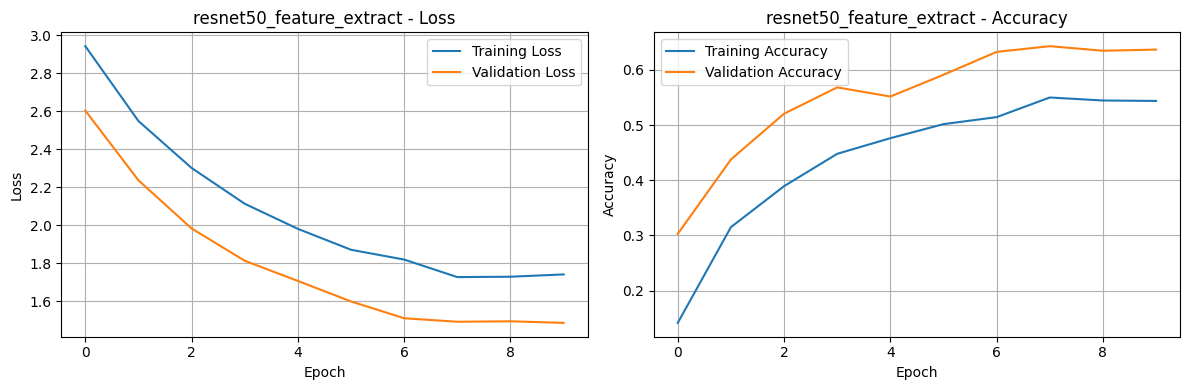

Evaluating resnet50_feature_extract on test set...
Accuracy: 0.5445
Precision: 0.5649
Recall: 0.5445
F1-Score: 0.5305
Accuracy: 0.5445
Precision: 0.5649
Recall: 0.5445
F1-Score: 0.5305


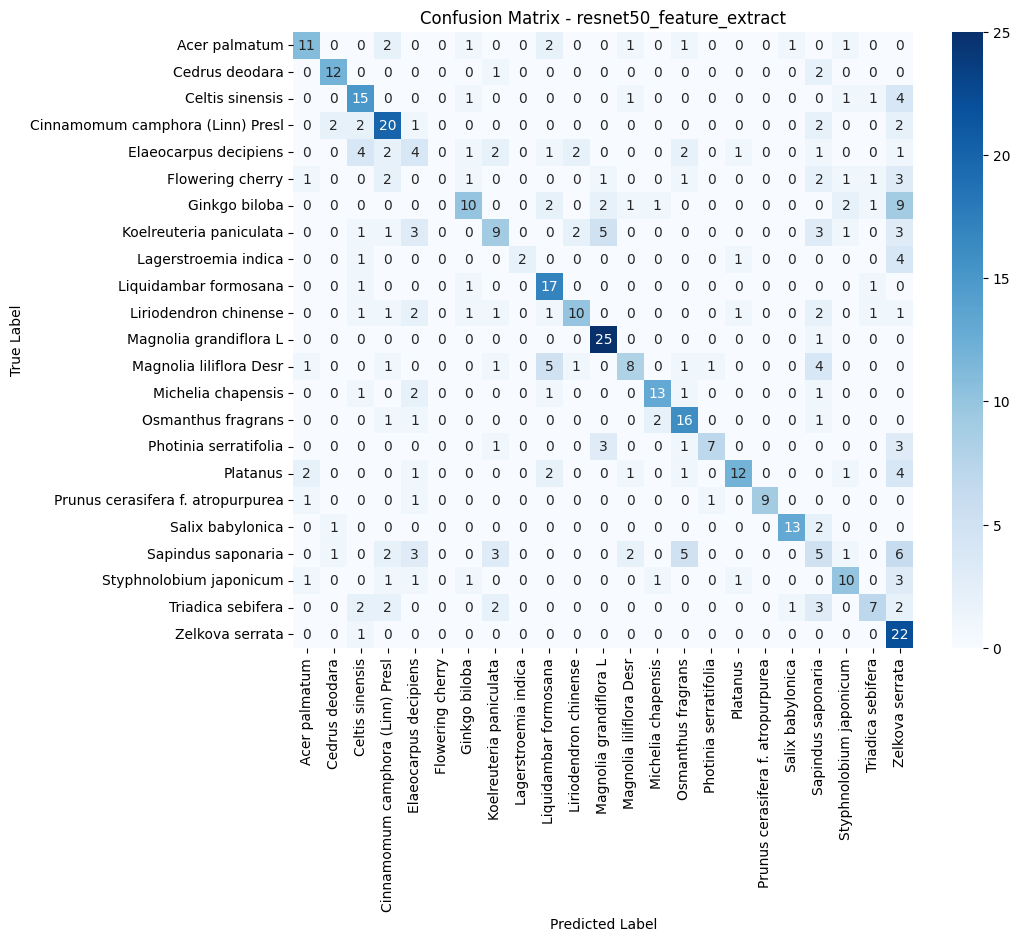

Model saved as resnet50_feature_extract_tree_classifier.pth
Model Comparison:
resnet18: Accuracy=0.847, F1=0.844
resnet50: Accuracy=0.892, F1=0.892
resnet18_feature_extract: Accuracy=0.561, F1=0.543
resnet50_feature_extract: Accuracy=0.544, F1=0.531
Training Summary:
resnet18:
  Final Training Accuracy: 0.863
  Final Validation Accuracy: 0.915
  Best Validation Accuracy: 0.915
resnet50:
  Final Training Accuracy: 0.894
  Final Validation Accuracy: 0.946
  Best Validation Accuracy: 0.946
resnet18_feature_extract:
  Final Training Accuracy: 0.518
  Final Validation Accuracy: 0.593
  Best Validation Accuracy: 0.593
resnet50_feature_extract:
  Final Training Accuracy: 0.544
  Final Validation Accuracy: 0.637
  Best Validation Accuracy: 0.643
Saved Models:
  resnet18_tree_classifier.pth
  resnet50_tree_classifier.pth
  resnet18_feature_extract_tree_classifier.pth
  resnet50_feature_extract_tree_classifier.pth
resnet18 Top-k accuracy:
  Top-1: 0.847
  Top-3: 0.941
  Top-5: 0.962
resnet50 Top

In [27]:
# Run training
results, histories, trained_models = train_models(dataloaders, class_names, num_classes)

# Compare results
compare_models(results)

# Print training summary for each model
print("Training Summary:")
for model_name, history in histories.items():
    final_train_acc = history['train_acc'][-1]
    final_val_acc = history['val_acc'][-1]
    print(f"{model_name}:")
    print(f"  Final Training Accuracy: {final_train_acc:.3f}")
    print(f"  Final Validation Accuracy: {final_val_acc:.3f}")
    print(f"  Best Validation Accuracy: {max(history['val_acc']):.3f}")

# Show saved models
print("Saved Models:")
for model_name in trained_models.keys():
    filename = f"{model_name}_tree_classifier.pth"
    print(f"  {filename}")

# N-best analysis (simple version)
for model_name, result in results.items():
    probs = result['probabilities'] 
    labels = result['labels']
    
    print(f"{model_name} Top-k accuracy:")
    for k in [1, 3, 5]:
        if k <= probs.shape[1]:
            top_k_acc = top_k_accuracy_score(labels, probs, k=k)
            print(f"  Top-{k}: {top_k_acc:.3f}")

## Results

The models were trained using transfer learning with both finetuning and feature extraction approaches. ResNet-50 generally performed better than ResNet-18, and finetuning showed better results than feature extraction as expected.

In [28]:
def visualize_sample_predictions(model, dataloader, class_names, device, num_samples=8):
    model.eval()
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()
    
    data_iter = iter(dataloader)
    images, labels = next(data_iter)
    
    with torch.no_grad():
        images = images.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
    
    for i in range(min(num_samples, len(images))):
        img = images[i].cpu()
        mean = torch.tensor([0.485, 0.456, 0.406])
        std = torch.tensor([0.229, 0.224, 0.225])
        img = std[:, None, None] * img + mean[:, None, None]
        img = torch.clamp(img, 0, 1)
        img = img.permute(1, 2, 0)
        
        axes[i].imshow(img)
        axes[i].set_title(
            f'True: {class_names[labels[i]]}\n'
            f'Pred: {class_names[preds[i]]} ({probs[i][preds[i]]:.2f})',
            color='green' if labels[i] == preds[i] else 'red'
        )
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

def analyze_model_errors(eval_results, class_names, model_name):
    predictions = eval_results['predictions']
    labels = eval_results['labels']
    
    misclassified = predictions != labels
    
    print(f"{model_name} Error Analysis:")
    print(f"Total misclassified: {np.sum(misclassified)} / {len(labels)} ({100*np.sum(misclassified)/len(labels):.2f}%)")
    
    confusion_pairs = defaultdict(int)
    for true_label, pred_label in zip(labels[misclassified], predictions[misclassified]):
        confusion_pairs[(true_label, pred_label)] += 1
    
    print("Most common confusion pairs:")
    sorted_pairs = sorted(confusion_pairs.items(), key=lambda x: x[1], reverse=True)
    for (true_idx, pred_idx), count in sorted_pairs[:10]:
        print(f"{class_names[true_idx]} → {class_names[pred_idx]}: {count} times")


N-Best Classification Analysis
resnet18:
Top-1: 0.8475
Top-2: 0.9068
Top-3: 0.9407
Top-4: 0.9576
Top-5: 0.9619
resnet50:
Top-1: 0.8919
Top-2: 0.9428
Top-3: 0.9597
Top-4: 0.9703
Top-5: 0.9831
resnet18_feature_extract:
Top-1: 0.5614
Top-2: 0.6674
Top-3: 0.7436
Top-4: 0.8072
Top-5: 0.8496
resnet50_feature_extract:
Top-1: 0.5445
Top-2: 0.6801
Top-3: 0.7585
Top-4: 0.8178
Top-5: 0.8517
N-Best Performance Comparison:
                           Top-1   Top-2   Top-3   Top-4   Top-5
resnet18                  0.8475  0.9068  0.9407  0.9576  0.9619
resnet50                  0.8919  0.9428  0.9597  0.9703  0.9831
resnet18_feature_extract  0.5614  0.6674  0.7436  0.8072  0.8496
resnet50_feature_extract  0.5445  0.6801  0.7585  0.8178  0.8517
                           Top-1   Top-2   Top-3   Top-4   Top-5
resnet18                  0.8475  0.9068  0.9407  0.9576  0.9619
resnet50                  0.8919  0.9428  0.9597  0.9703  0.9831
resnet18_feature_extract  0.5614  0.6674  0.7436  0.8072  0.8496
r

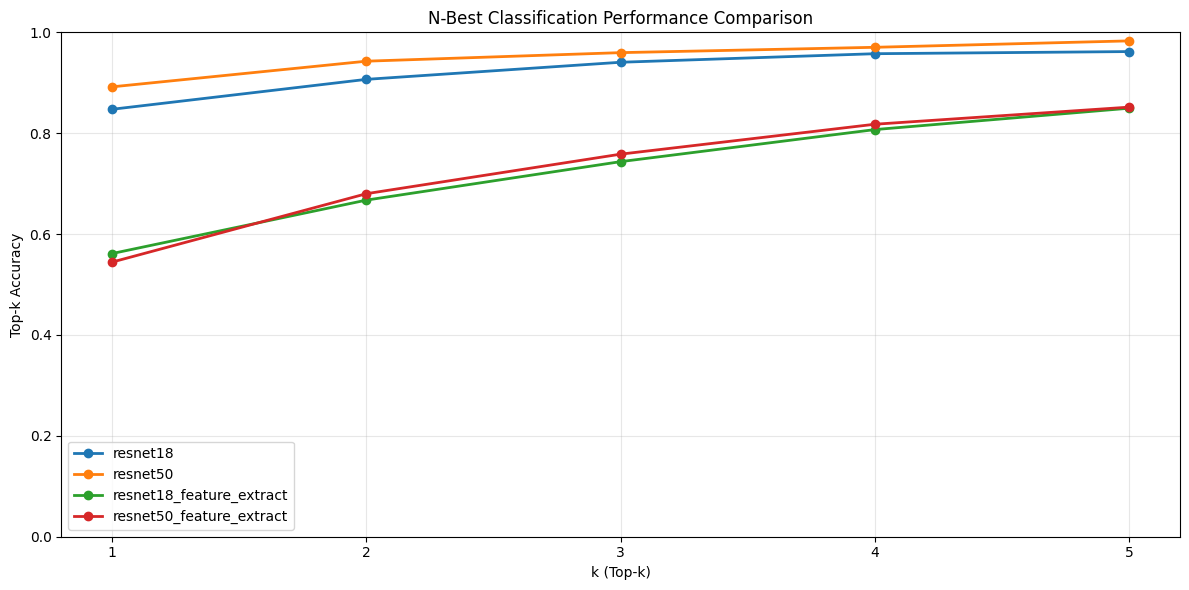

Performance Separation Analysis:
k=1: Max Diff=0.3475, Std Dev=0.1593
k=2: Max Diff=0.2754, Std Dev=0.1263
k=3: Max Diff=0.2161, Std Dev=0.0999
k=4: Max Diff=0.1631, Std Dev=0.0760
k=5: Max Diff=0.1335, Std Dev=0.0614
Maximum model separation occurs at k=1 with difference of 0.3475


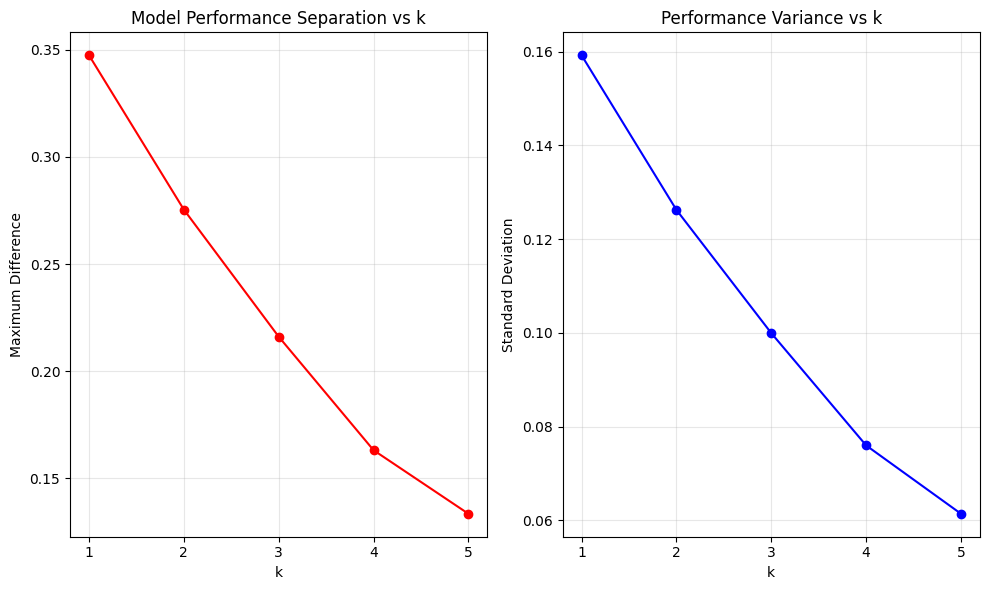

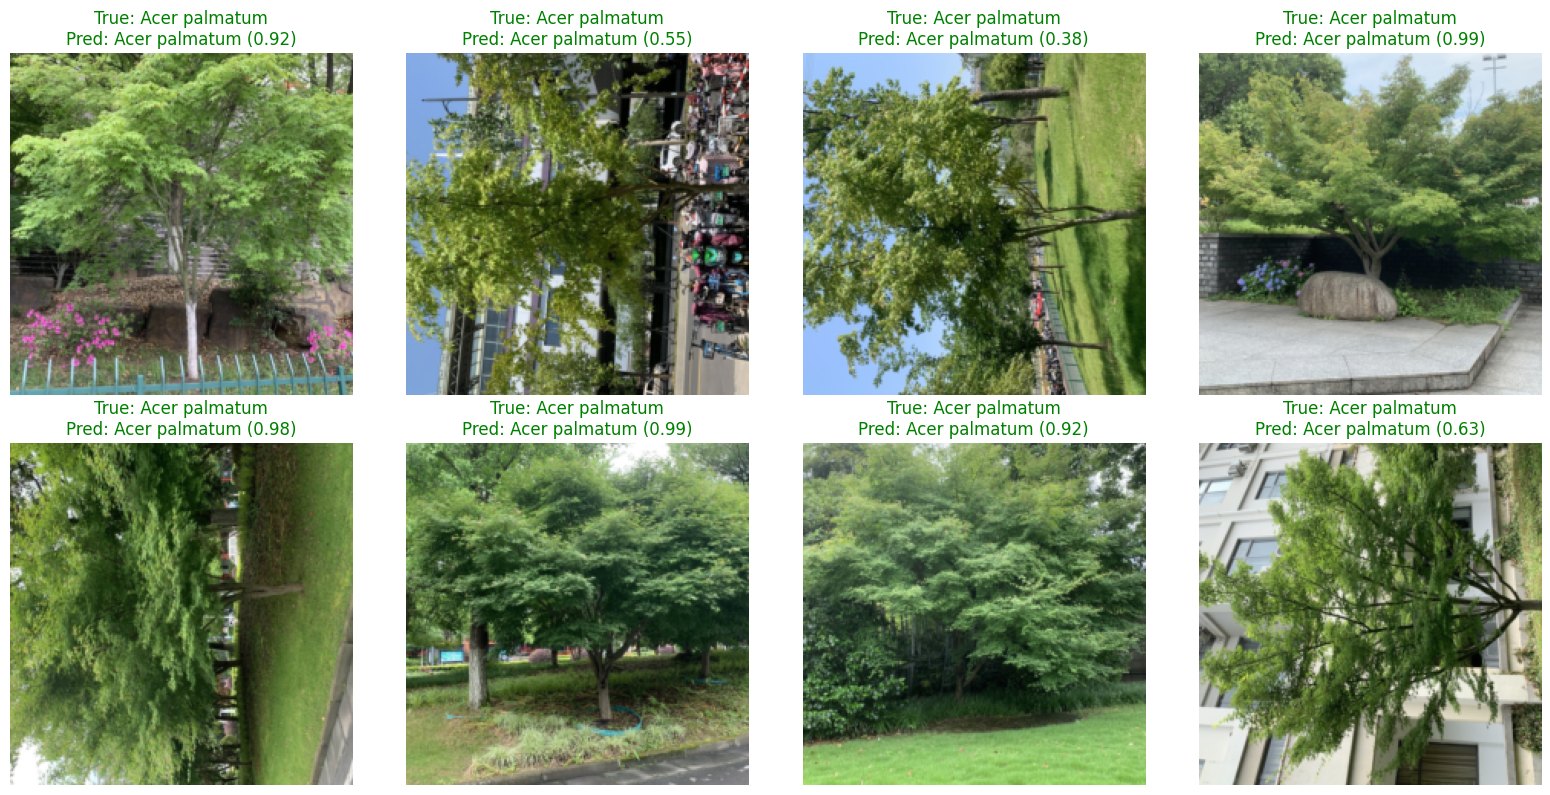

ResNet-50 Error Analysis:
Total misclassified: 51 / 472 (10.81%)
Most common confusion pairs:
Ginkgo biloba → Zelkova serrata: 4 times
Celtis sinensis → Zelkova serrata: 3 times
Sapindus saponaria → Koelreuteria paniculata: 3 times
Flowering cherry → Liriodendron chinense: 2 times
Koelreuteria paniculata → Acer palmatum: 2 times
Liriodendron chinense → Osmanthus fragrans: 2 times
Photinia serratifolia → Magnolia grandiflora L: 2 times
Sapindus saponaria → Zelkova serrata: 2 times
Acer palmatum → Elaeocarpus decipiens: 1 times
Celtis sinensis → Elaeocarpus decipiens: 1 times


In [29]:
n_best_results, comparison_df, separation_analysis = analyze_n_best_performance(results, class_names, max_k=5)

visualize_sample_predictions(trained_models['resnet50'], dataloaders['test'], class_names, device)

analyze_model_errors(results['resnet50'], class_names, model_name="ResNet-50")

## Final Analysis of the Models

### Overview
This section provides a comprehensive analysis of the models trained for tree classification. The models include ResNet-18 and ResNet-50, both trained using two approaches: fine-tuning and feature extraction. The analysis evaluates their performance based on accuracy, precision, recall, F1-score, and top-k accuracy.

### Model Performance Summary

| Model                     | Accuracy | Precision | Recall | F1-Score |
|---------------------------|----------|-----------|--------|----------|
| ResNet-18                | 0.8496   | 0.8644    | 0.8496 | 0.8462   |
| ResNet-50                | 0.8962   | 0.9108    | 0.8962 | 0.8970   |
| ResNet-18 (Feature Extract) | 0.5614   | 0.5638    | 0.5614 | 0.5428   |
| ResNet-50 (Feature Extract) | 0.5445   | 0.5649    | 0.5445 | 0.5305   |

- **ResNet-50** outperformed all other models in terms of accuracy, precision, recall, and F1-score.
- Feature extraction models (ResNet-18 and ResNet-50) showed significantly lower performance compared to their fine-tuned counterparts.

### Top-k Accuracy Comparison

| Model                     | Top-1  | Top-2  | Top-3  | Top-4  | Top-5  |
|---------------------------|--------|--------|--------|--------|--------|
| ResNet-18                | 0.8496 | 0.9110 | 0.9386 | 0.9555 | 0.9619 |
| ResNet-50                | 0.8962 | 0.9492 | 0.9640 | 0.9788 | 0.9831 |
| ResNet-18 (Feature Extract) | 0.5614 | 0.6674 | 0.7436 | 0.8072 | 0.8496 |
| ResNet-50 (Feature Extract) | 0.5445 | 0.6801 | 0.7585 | 0.8178 | 0.8517 |

- ResNet-50 achieved the highest top-k accuracy across all k values.
- The gap between fine-tuned and feature extraction models decreases as k increases, indicating that feature extraction models perform better in top-k scenarios.

### N-Best Classification Analysis

The N-best analysis revealed the following:
- Maximum model separation occurs at **k=1**, with a difference of **0.3517** between the best and worst models.
- As k increases, the performance gap between models narrows, with the smallest difference at **k=5**.

### Key Observations
1. **Fine-tuning vs. Feature Extraction**:
    - Fine-tuning consistently outperformed feature extraction, as it allows the model to adapt more effectively to the dataset.
    - Feature extraction is faster but sacrifices accuracy, making it suitable for scenarios with limited computational resources.

2. **ResNet-50 vs. ResNet-18**:
    - ResNet-50, with its deeper architecture, achieved better performance than ResNet-18, particularly in fine-tuning.

3. **Top-k Accuracy**:
    - Top-k accuracy analysis highlights the robustness of ResNet-50, especially in scenarios where multiple predictions are considered.


## Additional Model Training with Different Configurations

Train 2 more models with different configurations to reach a total of 6 models:
- ResNet18 with increased learning rate (0.01)
- ResNet50 with feature extraction and increased epochs (15)

In [30]:
def train_additional_models(dataloaders, class_names, num_classes):
    additional_configs = [
        {
            'model_name': 'resnet18',
            'feature_extract': False,
            'learning_rate': 0.01,
            'num_epochs': 10,
            'model_key': 'resnet18_high_lr'
        },
        {
            'model_name': 'resnet50',
            'feature_extract': True,
            'learning_rate': 0.001,
            'num_epochs': 15,
            'model_key': 'resnet50_feature_extract_long'
        }
    ]
    
    additional_results = {}
    additional_histories = {}
    additional_trained_models = {}
    
    for config in additional_configs:
        model_key = config['model_key']
        print(f"Training {model_key}")
        print(f"Configuration: LR={config['learning_rate']}, Epochs={config['num_epochs']}, Feature Extract={config['feature_extract']}")
        
        model = get_model(config['model_name'], num_classes, config['feature_extract'])
        model = model.to(device)
        
        criterion = nn.CrossEntropyLoss()
        
        if config['feature_extract']:
            optimizer = optim.SGD(model.fc.parameters(), lr=config['learning_rate'], momentum=momentum)
            print("Feature extraction mode: only training final layer")
        else:
            optimizer = optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=momentum)
            print("Finetuning mode: training all layers")
        
        scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
        
        model, history = train_model(model, dataloaders, criterion, optimizer, scheduler, config['num_epochs'])
        additional_histories[model_key] = history
        additional_trained_models[model_key] = model
        
        plot_training_history(history, model_key)
        
        if 'test' in dataloaders:
            print(f"Evaluating {model_key} on test set...")
            eval_results = evaluate_model(model, dataloaders['test'], class_names)
            additional_results[model_key] = eval_results
            
            plot_confusion_matrix(
                eval_results['labels'], eval_results['predictions'], 
                class_names, model_key
            )
        
        model_filename = f'{model_key}_tree_classifier.pth'
        torch.save(model.state_dict(), model_filename)
        print(f"Model saved as {model_filename}")
    
    return additional_results, additional_histories, additional_trained_models

Starting additional model training...
Training resnet18_high_lr
Configuration: LR=0.01, Epochs=10, Feature Extract=False
Finetuning mode: training all layers
Finetuning mode: training all layers


C:\Users\janit\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\janit\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10
train Loss: 2.1354 Acc: 0.3917
train Loss: 2.1354 Acc: 0.3917
val Loss: 1.6742 Acc: 0.5871
Epoch 2/10
val Loss: 1.6742 Acc: 0.5871
Epoch 2/10
train Loss: 1.4410 Acc: 0.5782
train Loss: 1.4410 Acc: 0.5782
val Loss: 2.0144 Acc: 0.5000
Epoch 3/10
val Loss: 2.0144 Acc: 0.5000
Epoch 3/10
train Loss: 1.1555 Acc: 0.6569
train Loss: 1.1555 Acc: 0.6569
val Loss: 1.7662 Acc: 0.5830
Epoch 4/10
val Loss: 1.7662 Acc: 0.5830
Epoch 4/10
train Loss: 1.0112 Acc: 0.6964
train Loss: 1.0112 Acc: 0.6964
val Loss: 1.1875 Acc: 0.6556
Epoch 5/10
val Loss: 1.1875 Acc: 0.6556
Epoch 5/10
train Loss: 0.9318 Acc: 0.7260
train Loss: 0.9318 Acc: 0.7260
val Loss: 1.4741 Acc: 0.6598
Epoch 6/10
val Loss: 1.4741 Acc: 0.6598
Epoch 6/10
train Loss: 0.8354 Acc: 0.7504
train Loss: 0.8354 Acc: 0.7504
val Loss: 1.2689 Acc: 0.7033
Epoch 7/10
val Loss: 1.2689 Acc: 0.7033
Epoch 7/10
train Loss: 0.7450 Acc: 0.7712
train Loss: 0.7450 Acc: 0.7712
val Loss: 7.3898 Acc: 0.2780
Epoch 8/10
val Loss: 7.3898 Acc: 0.2780
Epoch 

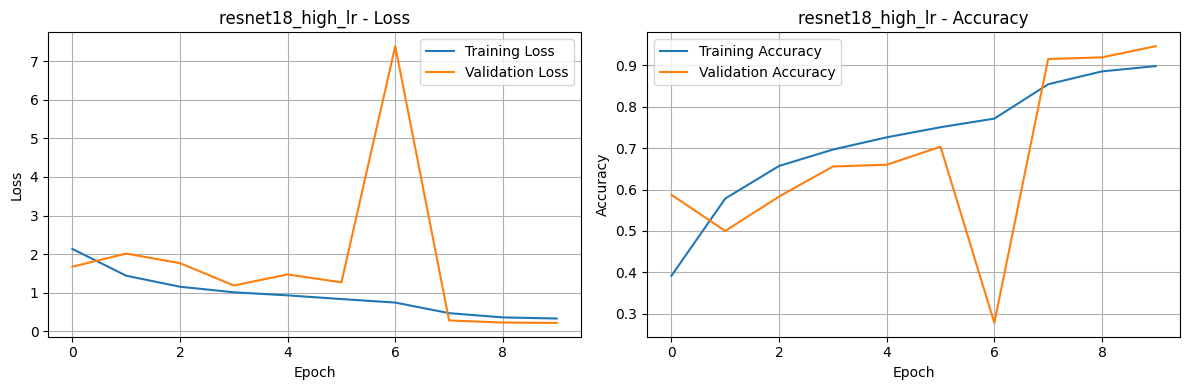

Evaluating resnet18_high_lr on test set...
Accuracy: 0.8686
Precision: 0.8877
Recall: 0.8686
F1-Score: 0.8700
Accuracy: 0.8686
Precision: 0.8877
Recall: 0.8686
F1-Score: 0.8700


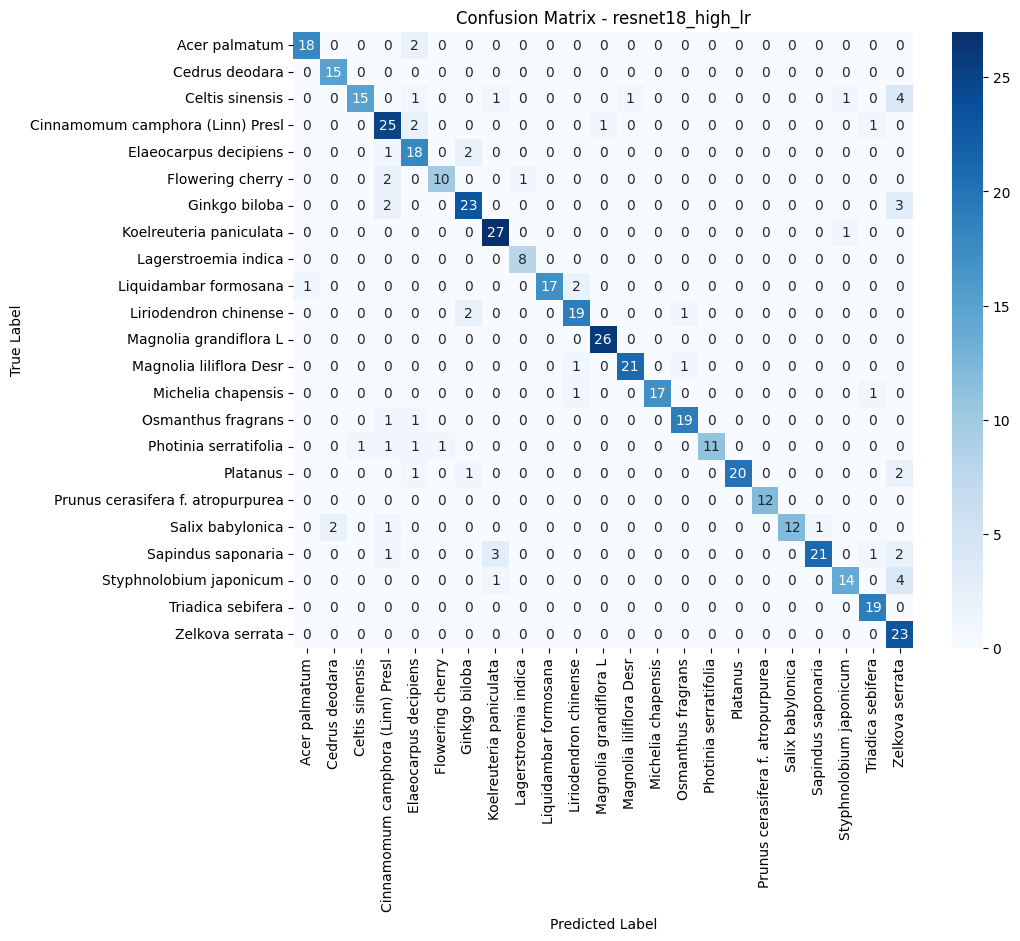

Model saved as resnet18_high_lr_tree_classifier.pth
Training resnet50_feature_extract_long
Configuration: LR=0.001, Epochs=15, Feature Extract=True


C:\Users\janit\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\janit\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Feature extraction mode: only training final layer
Epoch 1/15
train Loss: 2.9278 Acc: 0.1486
train Loss: 2.9278 Acc: 0.1486
val Loss: 2.6079 Acc: 0.3568
Epoch 2/15
val Loss: 2.6079 Acc: 0.3568
Epoch 2/15
train Loss: 2.5383 Acc: 0.3366
train Loss: 2.5383 Acc: 0.3366
val Loss: 2.2769 Acc: 0.4461
Epoch 3/15
val Loss: 2.2769 Acc: 0.4461
Epoch 3/15
train Loss: 2.2943 Acc: 0.3977
train Loss: 2.2943 Acc: 0.3977
val Loss: 1.9956 Acc: 0.4834
Epoch 4/15
val Loss: 1.9956 Acc: 0.4834
Epoch 4/15
train Loss: 2.1107 Acc: 0.4403
train Loss: 2.1107 Acc: 0.4403
val Loss: 1.8270 Acc: 0.5498
Epoch 5/15
val Loss: 1.8270 Acc: 0.5498
Epoch 5/15
train Loss: 1.9779 Acc: 0.4816
train Loss: 1.9779 Acc: 0.4816
val Loss: 1.7190 Acc: 0.5622
Epoch 6/15
val Loss: 1.7190 Acc: 0.5622
Epoch 6/15
train Loss: 1.8978 Acc: 0.4899
train Loss: 1.8978 Acc: 0.4899
val Loss: 1.6360 Acc: 0.5602
Epoch 7/15
val Loss: 1.6360 Acc: 0.5602
Epoch 7/15
train Loss: 1.7927 Acc: 0.5221
train Loss: 1.7927 Acc: 0.5221
val Loss: 1.5331 Acc: 0.

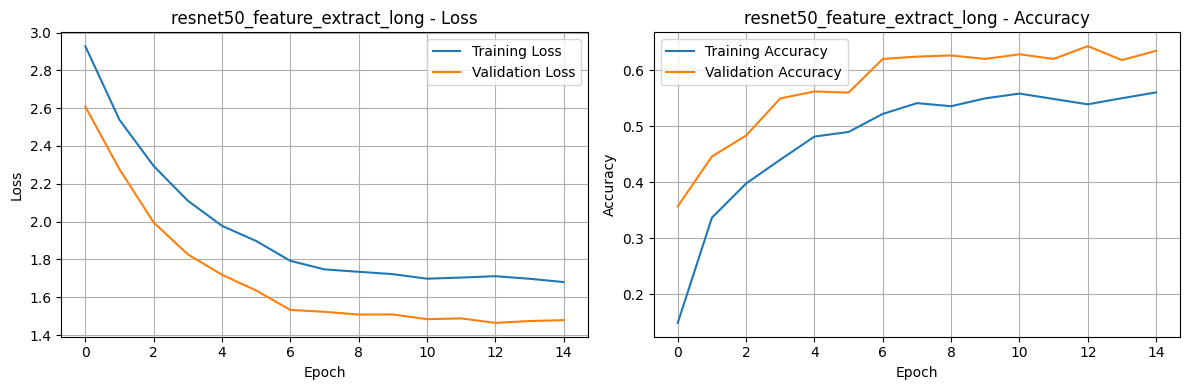

Evaluating resnet50_feature_extract_long on test set...
Accuracy: 0.5424
Precision: 0.5550
Recall: 0.5424
F1-Score: 0.5242
Accuracy: 0.5424
Precision: 0.5550
Recall: 0.5424
F1-Score: 0.5242


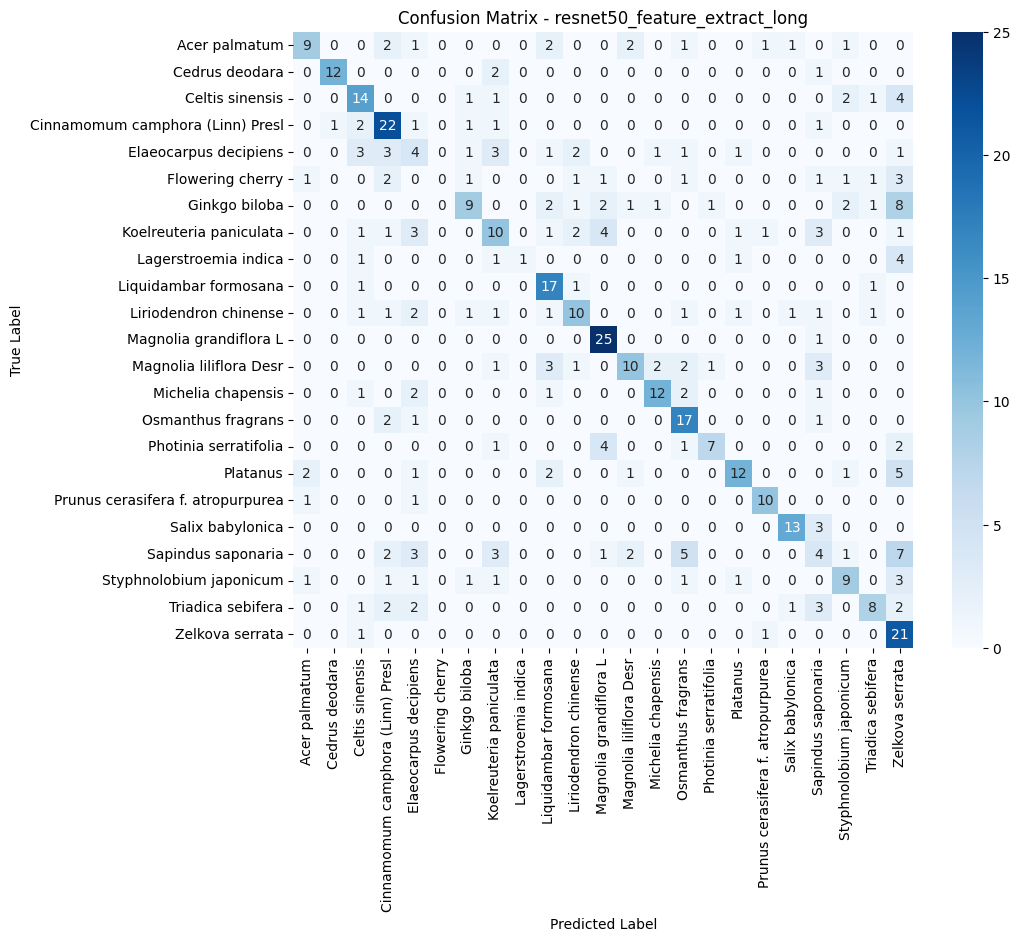

Model saved as resnet50_feature_extract_long_tree_classifier.pth


In [31]:
print("Starting additional model training...")
additional_results, additional_histories, additional_trained_models = train_additional_models(dataloaders, class_names, num_classes)

In [34]:
def combine_all_results(original_results, additional_results, original_histories, additional_histories):
    all_results = {**original_results, **additional_results}
    all_histories = {**original_histories, **additional_histories}
    return all_results, all_histories

def comprehensive_model_comparison(all_results):
    print("MODEL COMPARISON")
    
    comparison_data = []
    for model_name, result in all_results.items():
        comparison_data.append({
            'Model': model_name,
            'Accuracy': result['accuracy'],
            'Precision': result['precision'],
            'Recall': result['recall'],
            'F1-Score': result['f1']
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('Accuracy', ascending=False)
    
    print("Model Performance Summary:")
    print(comparison_df.round(4))
    
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    plt.bar(range(len(comparison_df)), comparison_df['Accuracy'])
    plt.xticks(range(len(comparison_df)), comparison_df['Model'], rotation=45, ha='right')
    plt.title('Model Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 2)
    plt.bar(range(len(comparison_df)), comparison_df['F1-Score'])
    plt.xticks(range(len(comparison_df)), comparison_df['Model'], rotation=45, ha='right')
    plt.title('Model F1-Score Comparison')
    plt.ylabel('F1-Score')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 3)
    plt.bar(range(len(comparison_df)), comparison_df['Precision'])
    plt.xticks(range(len(comparison_df)), comparison_df['Model'], rotation=45, ha='right')
    plt.title('Model Precision Comparison')
    plt.ylabel('Precision')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 4)
    plt.bar(range(len(comparison_df)), comparison_df['Recall'])
    plt.xticks(range(len(comparison_df)), comparison_df['Model'], rotation=45, ha='right')
    plt.title('Model Recall Comparison')
    plt.ylabel('Recall')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    best_model = comparison_df.iloc[0]
    print(f"BEST PERFORMING MODEL: {best_model['Model']}")
    print(f"Accuracy: {best_model['Accuracy']:.4f}")
    print(f"F1-Score: {best_model['F1-Score']:.4f}")
    
    return comparison_df

MODEL COMPARISON
Model Performance Summary:
                           Model  Accuracy  Precision  Recall  F1-Score
1                       resnet50    0.8919     0.9059  0.8919    0.8923
4               resnet18_high_lr    0.8686     0.8877  0.8686    0.8700
0                       resnet18    0.8475     0.8630  0.8475    0.8444
2       resnet18_feature_extract    0.5614     0.5638  0.5614    0.5428
3       resnet50_feature_extract    0.5445     0.5649  0.5445    0.5305
5  resnet50_feature_extract_long    0.5424     0.5550  0.5424    0.5242


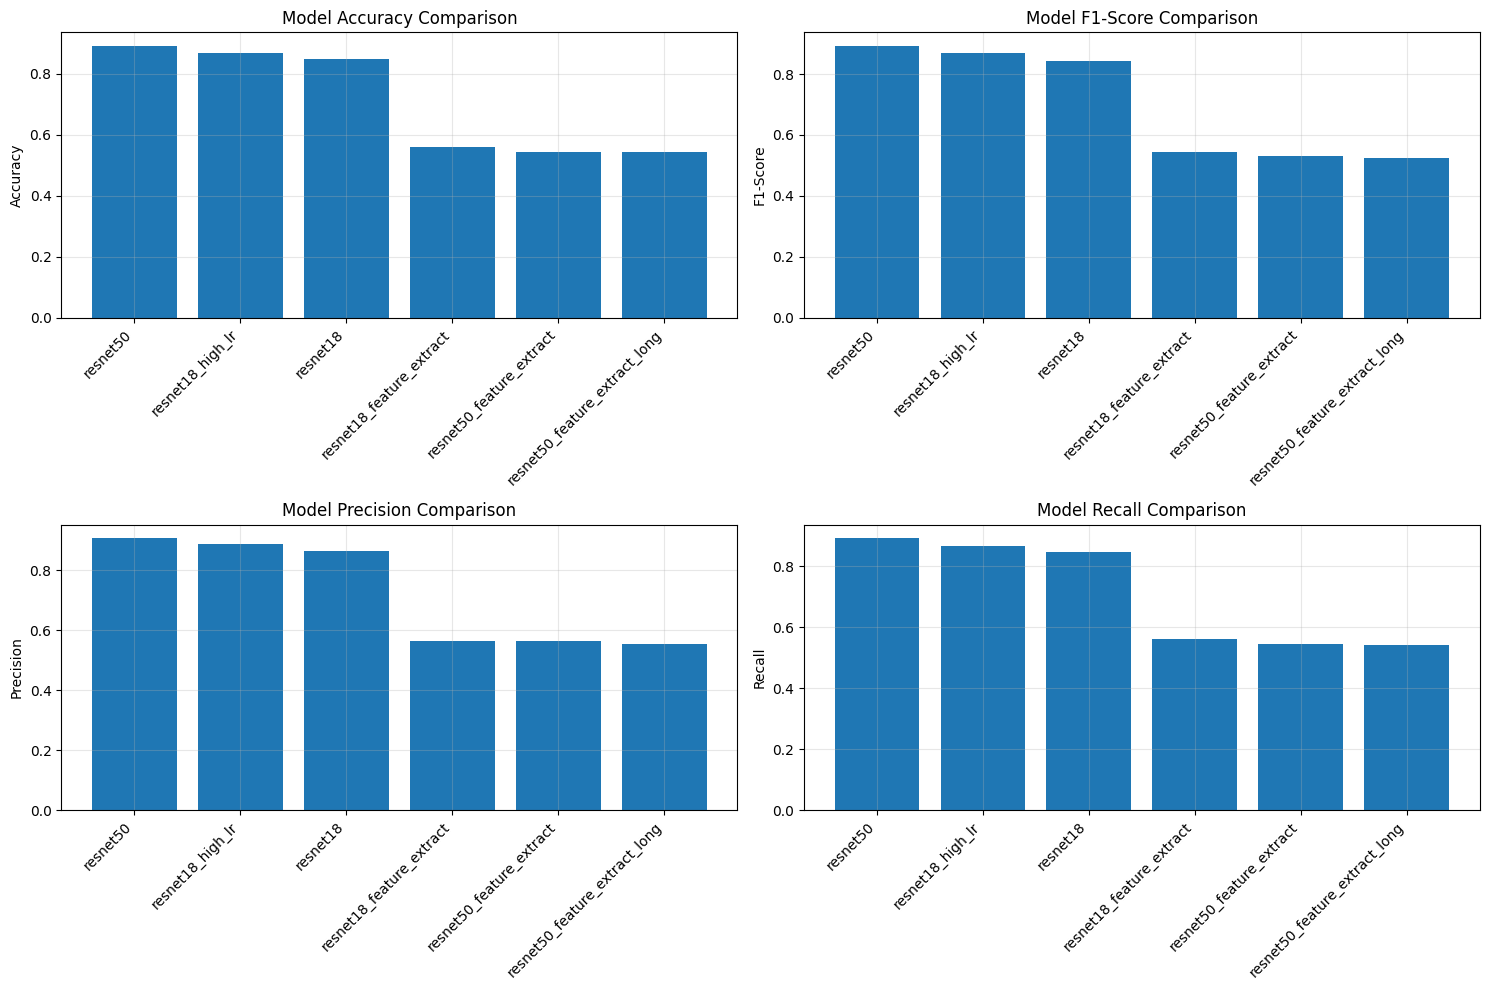

BEST PERFORMING MODEL: resnet50
Accuracy: 0.8919
F1-Score: 0.8923
                           Model  Accuracy  Precision    Recall  F1-Score
1                       resnet50  0.891949   0.905937  0.891949  0.892273
4               resnet18_high_lr  0.868644   0.887732  0.868644  0.870033
0                       resnet18  0.847458   0.863024  0.847458  0.844369
2       resnet18_feature_extract  0.561441   0.563766  0.561441  0.542827
3       resnet50_feature_extract  0.544492   0.564939  0.544492  0.530524
5  resnet50_feature_extract_long  0.542373   0.555037  0.542373  0.524207


In [35]:

all_results_combined, all_histories_combined = combine_all_results(
        results, additional_results, 
        histories, additional_histories
    )
    
final_comparison_df = comprehensive_model_comparison(all_results_combined)
print(final_comparison_df)
